# Lesion Classification Model Training
https://colab.research.google.com/drive/1PVcLHHxflI1GUlEYNjspOXL8LJaox7Ym#scrollTo=OkJs9Wn5l_HW

## Lesion Data Downloading

In [ ]:
!wget https://l.station307.com/EsLg1oEcYsC8xwHsPcHjJi/images.tar # Using station307 to transfer files from local computer to colab

--2024-04-19 04:19:51--  https://l.station307.com/EsLg1oEcYsC8xwHsPcHjJi/images.tar
Resolving l.station307.com (l.station307.com)... 51.158.131.31
Connecting to l.station307.com (l.station307.com)|51.158.131.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4808407040 (4.5G)
Saving to: ‘images.tar’

images.tar          100%[===================>]   4.48G  14.6MB/s    in 5m 24s  

2024-04-19 04:25:17 (14.1 MB/s) - ‘images.tar’ saved [4808407040/4808407040]



In [ ]:
!tar -xvf images.tar # Unzips the dataset of ~15k images

In [ ]:
!pip install livelossplot --quiet
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Cleaning and Preparation

Defining the lesion dataset object for PyTorch



In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image
import pandas as pd
import torch

class LesionDataset(torch.utils.data.Dataset):

  def __init__(self, transform = None, imgdir="./images/", center_crop = True):
    # Read the metadata from the isic downloads, in a csv
    self.df = pd.read_csv(os.path.join(imgdir, "benign/metadata.csv"))
    self.df = pd.concat([self.df, pd.read_csv(os.path.join(imgdir, "malignant/metadata.csv"))], ignore_index=True)

    self.center_crop = center_crop # saves center crop setting

    # Drops images that are copies of one another... there are a surprising number of these
    self.df.drop_duplicates(subset="lesion_id", inplace=True, keep='first')

    print("Images:", len(self.df))
    self.transform = transform

    # Compile a list of image paths and labels
    print(self.df["benign_malignant"].unique()) # Ensures that there are only two classes, benign and malignant

    # Removes excess benign images. There are ~2x as many benign images and malignant.
    self.df = self.df.iloc[sum(self.df["benign_malignant"] == "benign")-sum(self.df["benign_malignant"] == "malignant"):]

    # A list of each image's path
    self.imagepaths = [os.path.join(imgdir, f"{status}/{id}.JPG") for id, status in zip(self.df["isic_id"], self.df["benign_malignant"])]

     # Each image's ground truth tensor
    self.labels = [(torch.tensor([1.0, 0.0], dtype=torch.float32) if diagnosis == "benign" else (torch.tensor([0.0, 1.0], dtype=torch.float32))) for diagnosis in self.df["benign_malignant"]].

  # Returns the (x, y) pair
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.center_crop: # Crops to a square image at the center if specified in constructor
      min_dim = min(image.width, image.height)
      image = image.crop(((image.width - min_dim)//2, (image.height - min_dim)//2, min_dim + (image.width - min_dim)//2, min_dim + (image.height - min_dim)//2))
    if self.transform: # Applies the transform if specified in constructor
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples
  def __len__(self):
    return len(self.imagepaths)

Checking the quantity of benign and malignant data and verifying that the dataset correctly filters out excess benign data and duplicate images

In [ ]:
dataset = LesionDataset(imgdir="./images")
print("ORIGINAL DATA benign, malignant size")
print(sum(dataset.df["benign_malignant"] == "benign")) # Number of benign lesions in the dataframe
print(sum(dataset.df["benign_malignant"] == "malignant")) # Number of malignant lesions in the dataframe
print("FILTERED DATA benign, malignant size")
print(sum([l[1] == 0.0 for l in dataset.labels])) # Number of benign lesions in the labels (should be equal to dataframe)
print(sum([l[1] == 1.0 for l in dataset.labels])) # Number of malignant lesions in the labels (should be equal to dataframe)
print("FILTERED Lengths of underlying labels and images")
print(len(dataset.labels)) # Number of labels (should be equal to the number of images)
print(len(dataset.imagepaths)) # Number of images (should be equal to the number of images)

Images: 10994
['benign' 'malignant']
ORIGINAL DATA benign, malignant size
3489
3489
FILTERED DATA benign, malignant size
tensor(3489)
tensor(3489)
FILTERED Lengths of underlying labels and images
6978
6978


Displaying data, verifying that the dataset functions as expected

Images: 10994
['benign' 'malignant']
Length of train set: 5233
Length of validation set: 1745


<Figure size 640x480 with 0 Axes>

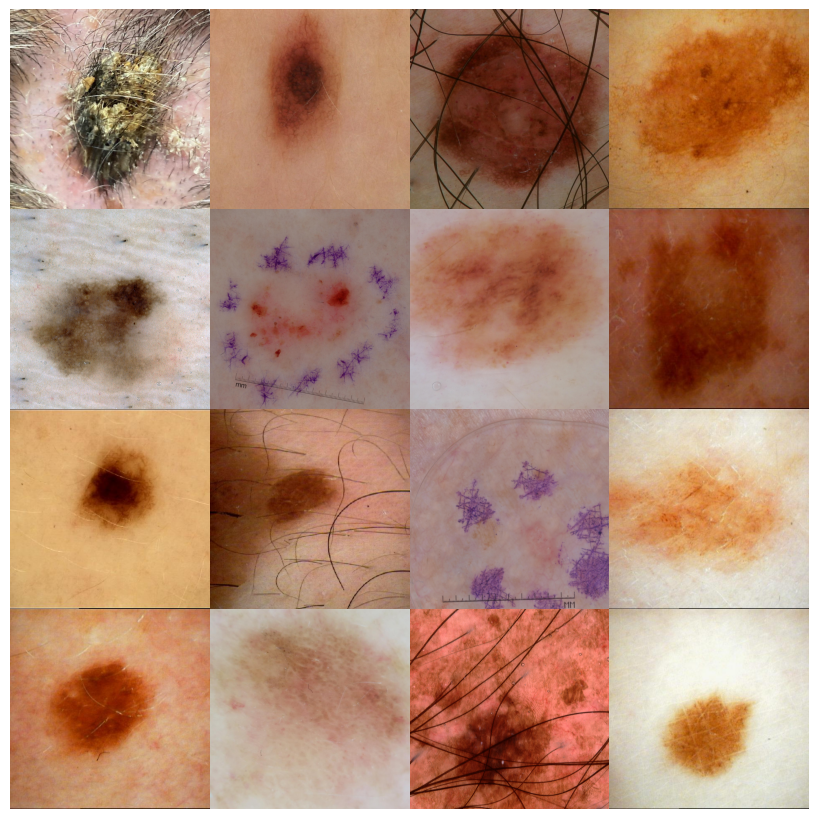

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import random_split

dataset = LesionDataset()
trainset, valset = random_split(dataset, [len(dataset)*3//4, len(dataset)-len(dataset)*3//4]) # train test split
print(f"Length of train set: {len(trainset)}")
print(f"Length of validation set: {len(valset)}")

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
  for j in range(4):
    img = trainset[i * 4 + j][0]
    # print(img.width, img.height)
    ax[i][j].imshow(img)
    ax[i][j].axis("off")
plt.tight_layout(pad=0)
plt.show()

## Model Training

Defining the training loop

In [ ]:
from livelossplot import PlotLosses
import torch
from torch.nn.functional import softmax

# Defining the device as a the CUDA GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def train_model(batch_size,
                n_epochs,
                learningRate,
                model,
                cost_function,
                optimizer,
                train_loader,
                val_loader):

  # Move everything to the GPU for calculation
  for param in model.parameters():
    param.data = param.data.float()
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Track the best accuracy and initialize the plot
  best_accuracy = 0
  liveloss = PlotLosses()

  # Begin the training loop
  for epoch in range(0, n_epochs):
    logs = {}

    # For each epoch, we keep track of the number of correct predictions, the total sum of the losses, and total number of samples for averaging
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model to training mode, allowing for gradient calculation and backpropogation
    model.train()

    # Divide the training dataset into batches
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()

      # Move data to GPU if possible
      xb = xb.to(device)

      # Run the batch through the model
      predicted = model(xb).to(device)

      # Compute the loss
      yb = yb.type(torch.FloatTensor).to(device)
      loss = cost_function(predicted, yb)
      print(loss.item()) # Display the loss function, allows us to keep track of progress
      cumulative_loss += loss.item()

      # Count the number of correct in each batch to track accuracy.
      # We find the max value in the prediction and the ground truth and check if they are the same category
      predicted_ = predicted.detach().softmax(dim = 1)
      max_vals, max_ids = predicted_.max(dim = 1)
      max_ybvals, max_ybids = yb.max(dim = 1)
      correct += (max_ids == max_ybids).sum().cpu().item()
      n_samples += xb.size(0) # Sometimes a batch is not a consistent size if the dataset size is not a multiple of the batch size

      # Computer gradients and backpropagate
      loss.backward()
      optimizer.step()

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Sets the model in evaluation mode. We don't implement dropout layers and others when running inference.
    model.eval()

    # To speed things up, we need no gradient calculations
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):
        xb = xb.to(device)
        predicted = model(xb).to(device)

        yb = yb.type(torch.FloatTensor).to(device)
        loss = cost_function(predicted, yb)
        print(loss.item())
        cumulative_loss += loss.item()

        predicted_ = predicted.detach().softmax(dim = 1)
        max_vals, max_ids = predicted_.max(dim = 1)
        max_ybvals, max_ybids = yb.max(dim = 1)
        correct += (max_ids == max_ybids).sum().cpu().item()
        n_samples += xb.size(0)

        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters if this iteration has the highest accuracy
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    # Update live loss plot
    liveloss.update(logs)
    liveloss.send()

  # Load the model parameters for the one that achieved the best val accuracy for future cells.
  model.load_state_dict(torch.load('best_model_so_far.pth'))

cuda


Initializing the pretrained ResNet-18 on IMAGENET-1k, replacing the fully connected layer with one that outputs 2 categories. Also, defining all variables needed for training

In [ ]:
# Include here any necessary code to define and setup your model.
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import random_split
import torchvision.transforms.functional as TF

# Initializing the pretrained model
pretrained_model = models.resnet18(pretrained = True)
pretrained_model.fc = torch.nn.Linear(pretrained_model.fc.in_features, 2)

batch_size = 256
n_epochs = 12
learningRate = 1.5e-3
cost_function = torch.nn.CrossEntropyLoss()
class RandomChoiceRotation: # Defining a transformation that will randomly rotate the images 0, 90, 180, or 270 degrees
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)

optimizer = torch.optim.SGD(pretrained_model.parameters(), lr = learningRate, weight_decay=0.001) # SGD optimizer appears to have the best performance
transform = transforms.Compose([transforms.Resize((224, 224)),
                                RandomChoiceRotation([0, 90, 180, 270]),
                                v2.RandomHorizontalFlip(p=0.5),
                                v2.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor()]) # Prepares image data to be sent into the model

# Defining the dataset for training, splitting into validation and training
dataset = LesionDataset(transform=transform)
trainset, valset = random_split(dataset, [len(dataset)*3//4, len(dataset)-len(dataset)*3//4])

# Defining data loaders to work with the training loop
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = batch_size,
                                           shuffle = True, # Adds variation in the data
                                           num_workers = 2) # Parallelizes the loading
val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size = batch_size,
                                         shuffle = False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Images: 10994
['benign' 'malignant']


Running the training loop. Below shows that we have gotten 93.5% accuracy!

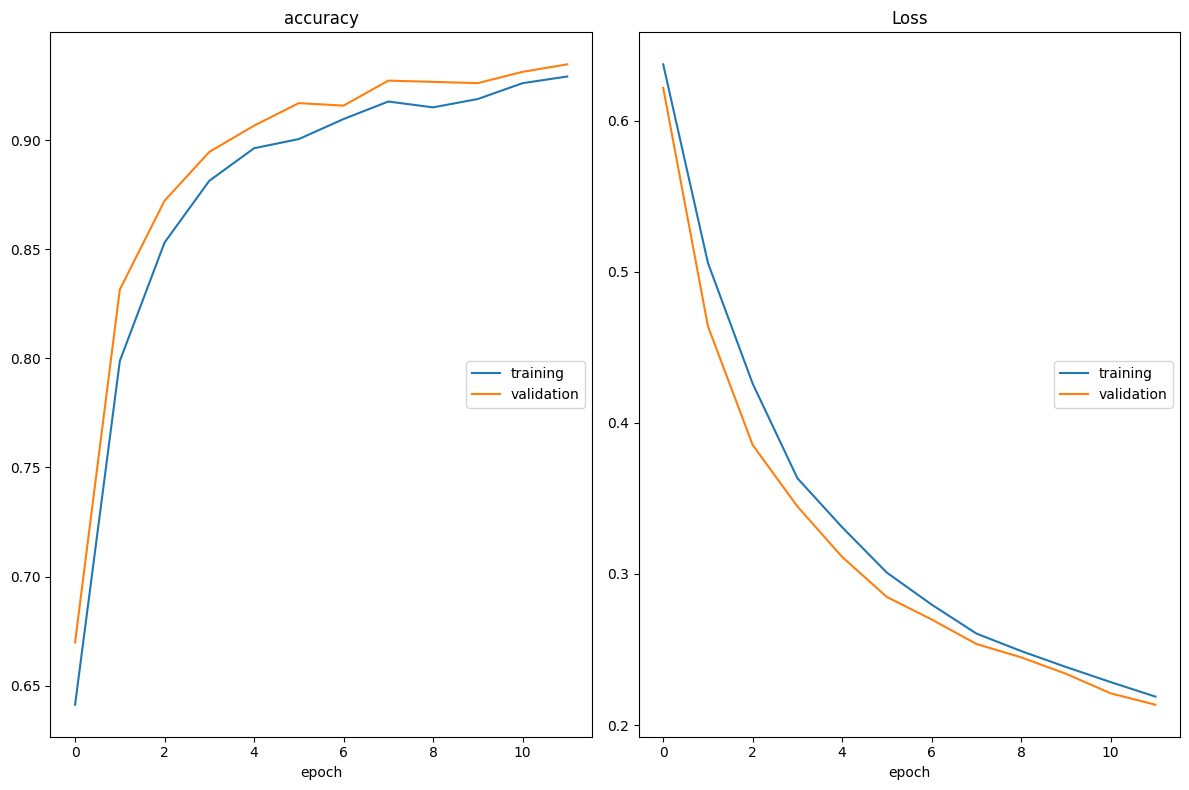

accuracy
	training         	 (min:    0.641, max:    0.929, cur:    0.929)
	validation       	 (min:    0.670, max:    0.935, cur:    0.935)
Loss
	training         	 (min:    0.219, max:    0.637, cur:    0.219)
	validation       	 (min:    0.213, max:    0.622, cur:    0.213)


In [ ]:
train_model(batch_size, n_epochs, learningRate,
            pretrained_model, cost_function, optimizer,
            train_loader, val_loader)

In [ ]:
# Loads the model into the drive because training takes a long time and usually finishes running in my sleep, and I dont want the session to disconnect
!cp best_model_so_far.pth "drive/Shareddrives/Big Team"